# Recommendation System on Amazon SageMaker (ObjectToVec)

We process the data with Spark, train it with XGBoost and deploy as Inference Pipeline

#### ObjectToVec
Object2Vec is a highly customizable multi-purpose algorithm that can learn embeddings of pairs of objects. The embeddings are learned such that it preserves their pairwise similarities in the original space.

- Similarity is user-defined: users need to provide the algorithm with pairs of objects that they define as similar (1) or dissimilar (0); alternatively, the users can define similarity in a continuous sense (provide a real-valued similarity score)
- The learned embeddings can be used to efficiently compute nearest neighbors of objects, as well as to visualize natural clusters of related objects in the embedding space. In addition, the embeddings can also be used as features of the corresponding objects in downstream supervised tasks such as classification or regression

In [29]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
%matplotlib inline
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import jsonlines
import boto3 
import csv
import io
import re
import s3fs
import copy
import random
import time


from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
from random import shuffle
import random
import datetime

import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [30]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()
s3_prefix = 'recomm-object2vec'     
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', s3_prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000001A2F33656C8>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : recomm-object2vec
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 2. Load Data

Dataset including number of users/moview are in official [Movielens website](https://grouplens.org/datasets/movielens/100k/)

In [4]:
## some utility functions

def load_csv_data(filename, delimiter, verbose=True):
    """
    input: a file readable as csv and separated by a delimiter
    and has format users - movies - ratings - etc
    output: a list, where each row of the list is of the form
    {'in0':userID, 'in1':movieID, 'label':rating}
    """
    to_data_list = list()
    users = list()
    movies = list()
    ratings = list()
    unique_users = set()
    unique_movies = set()
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            #if count!=0:
            to_data_list.append({'in0':[int(row[0])], 'in1':[int(row[1])], 'label':float(row[2])})
            users.append(row[0])
            movies.append(row[1])
            ratings.append(float(row[2]))
            unique_users.add(row[0])
            unique_movies.add(row[1])
    if verbose:
        print("In file {}, there are {} ratings".format(filename, len(ratings)))
        print("The ratings have mean: {}, median: {}, and variance: {}".format(
                                            round(np.mean(ratings), 2), 
                                            round(np.median(ratings), 2), 
                                            round(np.var(ratings), 2)))
        print("There are {} unique users and {} unique movies".format(len(unique_users), len(unique_movies)))
    return to_data_list


def csv_to_augmented_data_dict(filename, delimiter):
    """
    Input: a file that must be readable as csv and separated by delimiter (to make columns)
    has format users - movies - ratings - etc
    Output:
      Users dictionary: keys as user ID's; each key corresponds to a list of movie ratings by that user
      Movies dictionary: keys as movie ID's; each key corresponds a list of ratings of that movie by different users
    """
    to_users_dict = dict() 
    to_movies_dict = dict()
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=delimiter)
        for count, row in enumerate(reader):
            #if count!=0:
            if row[0] not in to_users_dict:
                to_users_dict[row[0]] = [(row[1], row[2])]
            else:
                to_users_dict[row[0]].append((row[1], row[2]))
            if row[1] not in to_movies_dict:
                to_movies_dict[row[1]] = list(row[0])
            else:
                to_movies_dict[row[1]].append(row[0])
    return to_users_dict, to_movies_dict


def user_dict_to_data_list(user_dict):
    # turn user_dict format to data list format (acceptable to the algorithm)
    data_list = list()
    for user, movie_rating_list in user_dict.items():
        for movie, rating in movie_rating_list:
            data_list.append({'in0':[int(user)], 'in1':[int(movie)], 'label':float(rating)})
    return data_list

def divide_user_dicts(user_dict, sp_ratio_dict):
    """
    Input: A user dictionary, a ration dictionary
         - format of sp_ratio_dict = {'train':0.8, "test":0.2}
    Output: 
        A dictionary of dictionaries, with key corresponding to key provided by sp_ratio_dict
        and each key corresponds to a subdivded user dictionary
    """
    ratios = [val for _, val in sp_ratio_dict.items()]
    assert np.sum(ratios) == 1, "the sampling ratios must sum to 1!"
    divided_dict = {}
    for user, movie_rating_list in user_dict.items():
        sub_movies_ptr = 0
        sub_movies_list = []
        #movie_list, _ = zip(*movie_rating_list)
        #print(movie_list)
        for i, ratio in enumerate(ratios):
            if i < len(ratios)-1:
                sub_movies_ptr_end = sub_movies_ptr + int(len(movie_rating_list)*ratio)
                sub_movies_list.append(movie_rating_list[sub_movies_ptr:sub_movies_ptr_end])
                sub_movies_ptr = sub_movies_ptr_end
            else:
                sub_movies_list.append(movie_rating_list[sub_movies_ptr:])
        for subset_name in sp_ratio_dict.keys():
            if subset_name not in divided_dict:
                divided_dict[subset_name] = {user: sub_movies_list.pop(0)}
            else:
                #access sub-dictionary
                divided_dict[subset_name][user] = sub_movies_list.pop(0)
    
    return divided_dict

def write_csv_to_jsonl(jsonl_fname, csv_fname, csv_delimiter):
    """
    Input: a file readable as csv and separated by delimiter (to make columns)
        - has format users - movies - ratings - etc
    Output: a jsonline file converted from the csv file
    """
    with jsonlines.open(jsonl_fname, mode='w') as writer:
        with open(csv_fname, 'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=csv_delimiter)
            for count, row in enumerate(reader):
                #print(row)
                #if count!=0:
                writer.write({'in0':[int(row[0])], 'in1':[int(row[1])], 'label':float(row[2])})
        print('Created {} jsonline file'.format(jsonl_fname))
                    
    
def write_data_list_to_jsonl(data_list, to_fname):
    """
    Input: a data list, where each row of the list is a Python dictionary taking form
    {'in0':userID, 'in1':movieID, 'label':rating}
    Output: save the list as a jsonline file
    """
    with jsonlines.open(to_fname, mode='w') as writer:
        for row in data_list:
            #print(row)
            writer.write({'in0':row['in0'], 'in1':row['in1'], 'label':row['label']})
    print("Created {} jsonline file".format(to_fname))

def data_list_to_inference_format(data_list, binarize=True, label_thres=3):
    """
    Input: a data list
    Output: test data and label, acceptable by SageMaker for inference
    """
    data_ = [({"in0":row['in0'], 'in1':row['in1']}, row['label']) for row in data_list]
    data, label = zip(*data_)
    infer_data = {"instances":data}
    if binarize:
        label = get_binarized_label(list(label), label_thres)
    return infer_data, label


def get_binarized_label(data_list, thres):
    """
    Input: data list
    Output: a binarized data list for recommendation task
    """
    for i, row in enumerate(data_list):
        if type(row) is dict:
            #if i < 10:
                #print(row['label'])
            if row['label'] > thres:
                #print(row)
                data_list[i]['label'] = 1
            else:
                data_list[i]['label'] = 0
        else:
            if row > thres:
                data_list[i] = 1
            else:
                data_list[i] = 0
    return data_list

In [7]:
## Load data and shuffle
path = os.path.abspath('./data/ml-100k')
train_path = os.path.join(path, 'ua.base')
valid_path = os.path.join(path, 'ua.test')
test_path = os.path.join(path, 'ub.test')

print('train_data :', train_path)
print('valid_data :', valid_path)
print('test_data :', test_path)

train_data : C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\data\ml-100k\ua.base
valid_data : C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\data\ml-100k\ua.test
test_data : C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\data\ml-100k\ub.test


In [8]:
train_data_list = load_csv_data(train_path, '\t')
random.shuffle(train_data_list)
validation_data_list = load_csv_data(valid_path, '\t')
random.shuffle(validation_data_list)

In file C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\data\ml-100k\ua.base, there are 90570 ratings
The ratings have mean: 3.52, median: 4.0, and variance: 1.27
There are 943 unique users and 1680 unique movies
In file C:\Users\bokhy\Desktop\Python\github\amazon-sagemaker\data\ml-100k\ua.test, there are 9430 ratings
The ratings have mean: 3.59, median: 4.0, and variance: 1.25
There are 943 unique users and 1129 unique movies


In [9]:
to_users_dict, to_movies_dict = csv_to_augmented_data_dict(train_path, '\t')

### 3. Data Pre-processing and EDA

The min, max, and median 'movies per user' is 10, 727, and 55.0
The min, max, and median 'users per movie' is 1, 495, and 25.0
In the training set
There are 213 users with no more than 20 movies
There are 12 movies with no more than 2 user


Text(0.5, 1.0, 'Users per movie')

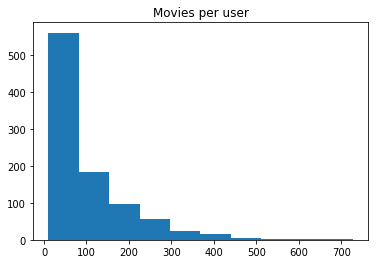

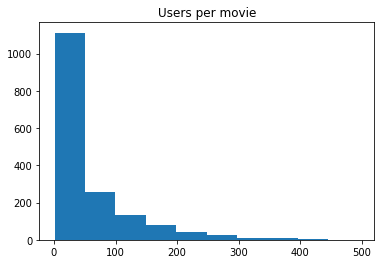

In [10]:
## Calculate min, max, median of number of movies per user
movies_per_user = [len(val) for key, val in to_users_dict.items()]

print("The min, max, and median 'movies per user' is {}, {}, and {}".format(np.amin(movies_per_user),
                                                                         np.amax(movies_per_user),
                                                                         np.median(movies_per_user)))
users_per_movie = [len(val) for key, val in to_movies_dict.items()]
print("The min, max, and median 'users per movie' is {}, {}, and {}".format(np.amin(users_per_movie),
                                                                         np.amax(users_per_movie),
                                                                          np.median(users_per_movie)))


count = 0
n_movies_lower_bound = 20
for n_movies in movies_per_user:
    if n_movies <= n_movies_lower_bound:
        count += 1
print("In the training set")
print('There are {} users with no more than {} movies'.format(count, n_movies_lower_bound))
#
count = 0
n_users_lower_bound = 2
for n_users in users_per_movie:
    if n_users <= n_users_lower_bound:
        count += 1
print('There are {} movies with no more than {} user'.format(count, n_users_lower_bound))


## figures

f = plt.figure(1)
plt.hist(movies_per_user)
plt.title("Movies per user")
##
g = plt.figure(2)
plt.hist(users_per_movie)
plt.title("Users per movie")

In [12]:
## Save training and validation data locally for rating-prediction (regression) task

write_data_list_to_jsonl(copy.deepcopy(train_data_list), './data/ml-100k/train_r.jsonl')
write_data_list_to_jsonl(copy.deepcopy(validation_data_list), './data/ml-100k/validation_r.jsonl')

Created ./data/ml-100k/train_r.jsonl jsonline file
Created ./data/ml-100k/validation_r.jsonl jsonline file


In [13]:
## Save training and validation data locally for recommendation (classification) task

### binarize the data 

train_c = get_binarized_label(copy.deepcopy(train_data_list), 3.0)
valid_c = get_binarized_label(copy.deepcopy(validation_data_list), 3.0)

write_data_list_to_jsonl(train_c, './data/ml-100k/train_c.jsonl')
write_data_list_to_jsonl(valid_c, './data/ml-100k/validation_c.jsonl')

Created ./data/ml-100k/train_c.jsonl jsonline file
Created ./data/ml-100k/validation_c.jsonl jsonline file


#### We check whether the two classes are balanced after binarization

In [14]:
train_c_label = [row['label'] for row in train_c]
valid_c_label = [row['label'] for row in valid_c]

print("There are {} fraction of positive ratings in train_c.jsonl".format(
                                np.count_nonzero(train_c_label)/len(train_c_label)))
print("There are {} fraction of positive ratings in validation_c.jsonl".format(
                                np.sum(valid_c_label)/len(valid_c_label)))

There are 0.5510213094843768 fraction of positive ratings in train_c.jsonl
There are 0.5799575821845175 fraction of positive ratings in validation_c.jsonl


We can see that it is pretty balanced 

### 4. (Optional) Baseline model to compare with our model

In [17]:
def get_mse_loss(res, labels):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    loss = 0
    for row, label in zip(res, labels):
        if type(row)is dict:
            loss += (row['scores'][0]-label)**2
        else:
            loss += (row-label)**2
    return round(loss/float(len(labels)), 2)

In [18]:
valid_r_data, valid_r_label = data_list_to_inference_format(copy.deepcopy(validation_data_list), binarize=False)

We first test the problem on two baseline algorithms

##### (1) predict using the global average of the user predictions in the training data

In [19]:
train_r_label = [row['label'] for row in copy.deepcopy(train_data_list)]

bs1_prediction = round(np.mean(train_r_label), 2)
print('The Baseline 1 (global rating average) prediction is {}'.format(bs1_prediction))
print("The validation mse loss of the Baseline 1 is {}".format(
                                     get_mse_loss(len(valid_r_label)*[bs1_prediction], valid_r_label)))

The Baseline 1 (global rating average) prediction is 3.52
The validation mse loss of the Baseline 1 is 1.26


##### (2) predict based on the user-averaged ratings of movies on training data

In [20]:
def bs2_predictor(test_data, user_dict, is_classification=False, thres=3):
    test_data = copy.deepcopy(test_data['instances'])
    predictions = list()
    for row in test_data:
        userID = str(row["in0"][0])
        # predict movie ID based on local average of user's prediction
        local_movies, local_ratings = zip(*user_dict[userID])
        local_ratings = [float(score) for score in local_ratings]
        predictions.append(np.mean(local_ratings))
        if is_classification:
            predictions[-1] = int(predictions[-1] > 3)
    return predictions

In [21]:
bs2_prediction = bs2_predictor(valid_r_data, to_users_dict, is_classification=False)
print("The validation loss of the Baseline 2 (user-based rating average) is {}".format(
                                     get_mse_loss(bs2_prediction, valid_r_label)))

The validation loss of the Baseline 2 (user-based rating average) is 1.09


### 5. Upload data to S3 bucket

In [31]:
s3_data_path = "s3://{}/{}/data".format(bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(bucket, s3_prefix)

In [33]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [34]:
%%time
copy_to_s3("train_r.jsonl", s3_data_path + "/train/train_r.jsonl")
copy_to_s3("validation_r.jsonl", s3_data_path + "/validation/validation_r.jsonl")

Uploading file to s3://sagemaker-us-west-2-570447867175/recomm-object2vec/data/train/train_r.jsonl
Uploading file to s3://sagemaker-us-west-2-570447867175/recomm-object2vec/data/validation/validation_r.jsonl
Wall time: 4.3 s


### 6. Start Training

In [35]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'object2vec','latest')
print('Algorithm :', container)

Algorithm : 174872318107.dkr.ecr.us-west-2.amazonaws.com/object2vec:latest


##### (1) Define training hyperparameters

Feel Free to play around with hyperparameters to get the best record

In [41]:
hyperparameters = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3,
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 1024,
    "epochs": 10,
    "learning_rate": 0.001,
    "mini_batch_size": 64,
    "mlp_activation": "tanh",
    "mlp_dim": 256,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "mean_squared_error"
}

##### (2) Create 'Estimator' to start training job

In [42]:
regressor = sagemaker.estimator.Estimator(container,
                                          role, 
                                          train_instance_count=1, 
                                          train_instance_type='ml.m4.xlarge',
                                          output_path=s3_output_path,
                                          sagemaker_session=sess)

## set hyperparameters
regressor.set_hyperparameters(**hyperparameters)

## train the model
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/validation/".format(s3_data_path)
}

regressor.fit(inputs=data_channels, wait=True)

2020-07-01 00:51:27 Starting - Starting the training job...
2020-07-01 00:51:29 Starting - Launching requested ML instances......
2020-07-01 00:52:38 Starting - Preparing the instances for training...
2020-07-01 00:53:31 Downloading - Downloading input data...
2020-07-01 00:53:56 Training - Downloading the training image...
2020-07-01 00:54:30 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/01/2020 00:54:33 INFO 139885740795712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embedding_st

Now our model data will start training with the given algorithm and data  

But, what if we want to send additional unlabeled data to the algorithm and get predictions from the trained model? This step is called **inference** in the Sagemaker. Next, we demonstrate how to use a trained model to perform inference on unseen data points.

### 7. Deploy the model (Inference)

In [43]:
from sagemaker.predictor import json_serializer, json_deserializer

# create a model using the trained algorithm
regression_model = regressor.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')

In [44]:
# deploy the model
predictor = regression_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------!

Below we send validation data (without labels) to the deployed endpoint for inference. We will see that the resulting prediction error we get from post-training inference matches the best validation error from the training log in the console above (up to floating point error). If you follow the training instruction and parameter setup, you should get mean squared error on the validation set approximately 0.91.

In [45]:
# Send data to the endpoint to get predictions
prediction = predictor.predict(valid_r_data)

print("The mean squared error on validation set is %.3f" %get_mse_loss(prediction, valid_r_label))

The mean squared error on validation set is 0.930


### 8. Predicting and evaluating with the test set

In this section, we showcase how to use Object2Vec to recommend movies, using the binarized rating labels. Here, if a movie rating label for a given user is binarized to 1, then it means that the movie should be recommended to the user; otherwise, the label is binarized to 0. The binarized data set is already obtained in the preprocessing section, so we will proceed to apply the algorithm.

We upload the binarized datasets for classification task to S3

In [49]:
%%time
copy_to_s3("./data/ml-100k/train_c.jsonl", s3_data_path + "/train/train_c.jsonl")
copy_to_s3("./data/ml-100k/validation_c.jsonl", s3_data_path + "/validation/validation_c.jsonl")

Uploading file to s3://sagemaker-us-west-2-570447867175/recomm-object2vec/data/train/train_c.jsonl
Uploading file to s3://sagemaker-us-west-2-570447867175/recomm-object2vec/data/validation/validation_c.jsonl
Wall time: 4 s


##### Below steps resembles above training steps

In [51]:
s3_data_path

's3://sagemaker-us-west-2-570447867175/recomm-object2vec/data'

In [52]:
hyperparameters_c = {
    "_kvstore": "device",
    "_num_gpus": "auto",
    "_num_kv_servers": "auto",
    "bucket_width": 0,
    "early_stopping_patience": 3, 
    "early_stopping_tolerance": 0.01,
    "enc0_cnn_filter_width": 3,
    "enc0_layers": "auto",
    "enc0_max_seq_len": 1,
    "enc0_network": "pooled_embedding",
    "enc0_token_embedding_dim": 300,
    "enc0_vocab_size": 944,
    "enc1_cnn_filter_width": 3,
    "enc1_layers": "auto",
    "enc1_max_seq_len": 1,
    "enc1_network": "pooled_embedding",
    "enc1_token_embedding_dim": 300,
    "enc1_vocab_size": 1684,
    "enc_dim": 2048,
    "epochs": 10,
    "learning_rate": 0.001,
    "mini_batch_size": 2048,
    "mlp_activation": "relu",
    "mlp_dim": 1024,
    "mlp_layers": 1,
    "num_classes": 2,
    "optimizer": "adam",
    "output_layer": "softmax"
}

## get estimator
classifier = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.p2.xlarge',
                                    output_path=s3_output_path,
                                    sagemaker_session=sess)

## set hyperparameters
classifier.set_hyperparameters(**hyperparameters_c)


## train the model
data_channels = {
    "train": "{}/train/train_c.jsonl".format(s3_data_path),
    "test": "{}/validation/validation_c.jsonl".format(s3_data_path)
}

classifier.fit(inputs=data_channels, wait=True)


# create the model
classification_model = classifier.create_model(
                        serializer=json_serializer,
                        deserializer=json_deserializer,
                        content_type='application/json')
# Deploy the model
predictor_2 = classification_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

# change test-set into correct format
valid_c_data, valid_c_label = data_list_to_inference_format(copy.deepcopy(validation_data_list), 
                                                            label_thres=3, binarize=True)
# prediction on test-set
predictions = predictor_2.predict(valid_c_data)

2020-07-01 03:02:43 Starting - Starting the training job...
2020-07-01 03:02:46 Starting - Launching requested ML instances......
2020-07-01 03:03:55 Starting - Preparing the instances for training......
2020-07-01 03:05:15 Downloading - Downloading input data
2020-07-01 03:05:15 Training - Downloading the training image......
2020-07-01 03:06:08 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/01/2020 03:06:13 INFO 140313708324672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'comparator_list': u'hadamard, concat, abs_diff', u'enc0_vocab_file': u'', u'output_layer': u'softmax', u'enc0_cnn_filter_width': 3, u'epochs': 30, u'mlp_dim': 512, u'enc0_freeze_pretrained_embedding': u'true', u'mlp_layers': 2, u'_num_kv_servers': u'auto', u'weight_decay': 0, u'enc0_pretrained_embedding_file': u'', u'token_embedding_

---------------!

In [53]:
# Helper function to get accuracy
def get_class_accuracy(res, labels, thres):
    if type(res) is dict:
        res = res['predictions']
    assert len(res)==len(labels), 'result and label length mismatch!'
    accuracy = 0
    for row, label in zip(res, labels):
        if type(row) is dict:
            if row['scores'][1] > thres:
                prediction = 1
            else: 
                prediction = 0
            if label > thres:
                label = 1
            else:
                label = 0
            accuracy += 1 - (prediction - label)**2
    return accuracy / float(len(res))

print("The accuracy on the binarized validation set is %.3f" %get_class_accuracy(predictions, valid_c_label, 0.5))

The accuracy on the binarized validation set is 0.699


### 9. Movie retrieval in the embedding space

Since Object2Vec transforms user and movie ID's into embeddings as part of the training process. After training, it obtains user and movie embeddings in the left and right encoders, respectively. Intuitively, the embeddings should be tuned by the algorithm in a way that facilitates the supervised learning task: since for a specific user, similar movies should have similar ratings, we expect that similar movies should be close-by in the embedding space.

In this section, we demonstrate how to find the nearest-neighbor (in Euclidean distance) of a given movie ID, among all movie ID's.

In [54]:
def get_movie_embedding_dict(movie_ids, trained_model):
    input_instances = list()
    for s_id in movie_ids:
        input_instances.append({'in1': [s_id]})
    data = {'instances': input_instances}
    movie_embeddings = trained_model.predict(data)
    embedding_dict = {}
    for s_id, row in zip(movie_ids, movie_embeddings['predictions']):
        embedding_dict[s_id] = np.array(row['embeddings'])
    return embedding_dict


def load_movie_id_name_map(item_file):
    movieID_name_map = {}
    with open(item_file, 'r', encoding="ISO-8859-1") as f:
        for row in f.readlines():
            row = row.strip()
            split = row.split('|')
            movie_id = split[0]
            movie_name = split[1]
            sparse_tags = split[-19:]
            movieID_name_map[int(movie_id)] = movie_name 
    return movieID_name_map

            
def get_nn_of_movie(movie_id, candidate_movie_ids, embedding_dict):
    movie_emb = embedding_dict[movie_id]
    min_dist = float('Inf')
    best_id = candidate_movie_ids[0]
    for idx, m_id in enumerate(candidate_movie_ids):
        candidate_emb = embedding_dict[m_id]
        curr_dist = np.linalg.norm(candidate_emb - movie_emb)
        if curr_dist < min_dist:
            best_id = m_id
            min_dist = curr_dist
    return best_id, min_dist


def get_unique_movie_ids(data_list):
    unique_movie_ids = set()
    for row in data_list:
        unique_movie_ids.add(row['in1'][0])
    return list(unique_movie_ids)

In [55]:
train_data_list = load_csv_data(train_path, '\t', verbose=False)
unique_movie_ids = get_unique_movie_ids(train_data_list)
embedding_dict = get_movie_embedding_dict(unique_movie_ids, predictor_2)
candidate_movie_ids = unique_movie_ids.copy()

##### Script below can show what is the closest movie to any movie in the data set. You can find the movie name and ID pair in the 'u.item' file

In [64]:
movie_id_to_examine = 312 # Customize the movie ID

In [65]:
candidate_movie_ids.remove(movie_id_to_examine)
best_id, min_dist = get_nn_of_movie(movie_id_to_examine, candidate_movie_ids, embedding_dict)
movieID_name_map = load_movie_id_name_map('./data/ml-100k/u.item')
print('The closest movie to {} in the embedding space is {}'.format(movieID_name_map[movie_id_to_examine],
                                                                  movieID_name_map[best_id]))
candidate_movie_ids.append(movie_id_to_examine)

The closest movie to Midnight in the Garden of Good and Evil (1997) in the embedding space is Men With Guns (1997)


### 10. Close the SageMaker Instance

In [66]:
## clean up
sess.delete_endpoint(predictor.endpoint)
sess.delete_endpoint(predictor_2.endpoint)